![](images/waste_classification.jpg)
    Image from [this article](https://www.usnews.com/news/world-report/articles/2019-05-28/malaysia-to-ship-plastic-trash-back-to-the-us-other-origin-countries)

# Problem Statement
In 2017 China stopped accepting recycled material with less than 99.5% purity.  At that point many of our recyclables started making their way to South East Asia and Africa where they are dumped or burned rather than recycled causing health and environmental problems in those regions.

To solve this we need an array of strategies to increase the purity of our sorted recyclables.

The project is an exploration of using deep neural networks for classification of waste images using the Azure's python sdk and the resources of the Microsoft Azure Machine Learning Studio.

# Import Data

The data was created by Mandy Yang and Gary Thung for their paper [Classification of Trash for Recyclability Status](http://cs229.stanford.edu/proj2016/report/ThungYang-ClassificationOfTrashForRecyclabilityStatus-report.pdf).

The data is also available on kaggle [here](https://www.kaggle.com/asdasdasasdas/garbage-classification)

In [1]:
# imports
import os
import shutil

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                  array_to_img, 
                                                  img_to_array, 
                                                  load_img)

from azureml.core import Workspace, Dataset, ScriptRunConfig, Experiment
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.compute import AmlCompute, ComputeTarget

from utils import count_files

In [2]:
# view categories
categories = os.listdir('data/raw')
categories

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [3]:
# count the number of images in each category
image_paths = {}
for cat in categories:
    image_paths[cat] = os.listdir(os.path.join('data/raw',cat))
    print('There are', len(os.listdir(os.path.join('data/raw',cat))), 
          cat, 
          'images' )
    

There are 594 paper images
There are 410 metal images
There are 403 cardboard images
There are 137 trash images
There are 501 glass images
There are 482 plastic images


This dataset is small is fairly small.  Lets take a look at what it contains.

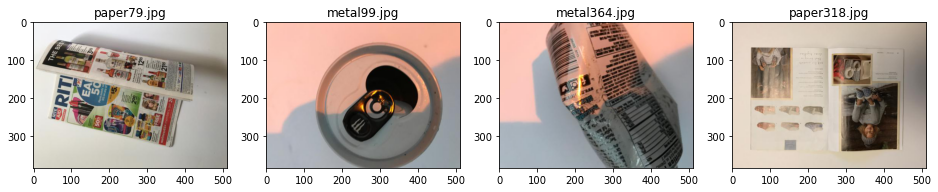

In [4]:
# inspect random images
fig, axs = plt.subplots(1,4, figsize=(16,4))
                        
for ax in axs:
    # choose a random category
    cat = np.random.choice(categories)
    
    # choose a random image in that category
    file_name = np.random.choice(os.listdir(os.path.join('data/raw',cat)))
    
    # load and display the image
    img = load_img(os.path.join('data/raw',cat,file_name))
    ax.imshow(img)
    ax.set_title(file_name)

# Split into train, validation, test

In [5]:
# set proportion of each class to hold for validation and testing.
val_portion = 0.05
test_portion = 0.05

split_base = 'data/split'

# remove the folder if it exists and rerun the split
if os.path.isdir(split_base):
    shutil.rmtree(split_base)

os.mkdir(split_base)

# store the path of each folder and create directories
train_folder = os.path.join(split_base, 'train')
os.mkdir(train_folder)

val_folder = os.path.join(split_base, 'validation')
os.mkdir(val_folder)

test_folder = os.path.join(split_base, 'test')
os.mkdir(test_folder)



In [6]:
# Split the data into training, validation, and split folders
for cat in categories:
    # get total number of files in this category
    num_files = len(image_paths[cat])
    
    # randomize the file order for this category
    np.random.shuffle(image_paths[cat])
    
    # set split boundries for validation and test
    validation_boundry = int(np.floor(num_files * val_portion))
    test_boundry = int(np.floor(num_files * test_portion) + validation_boundry)
        
    # store boundries
    labels = {'validation': image_paths[cat][:validation_boundry],
              'test': image_paths[cat][validation_boundry:test_boundry],
              'train': image_paths[cat][test_boundry:]}
    
    # loop through boundries and move copy files
    for label, files in labels.items():
        # create folder
        os.mkdir(os.path.join(split_base, label, cat))
        
        # copy files to the correct directory
        for file in files:
            shutil.copyfile(os.path.join('data/raw', cat, file),
                            os.path.join(split_base, label, cat, file))


In [7]:
# Check number of files in each folder
# count_files is a custom function in utils.py
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)

print('Total training files:', num_train)
print('Total validation files:', num_val)
print('Total testing files:', num_test)


Total training files: 2279
Total validation files: 124
Total testing files: 124


Training size should be divisible by 32 to make sure each epoch contains all of the images when I train the models.  The closest number divisible by 32 is 2272 so I will move 7 files to the validation and/or testing sets.  I will move them to to validation.

In [8]:
# the the folder and number of files in it for each class in the training set
folders = [(f.path, len(os.listdir(f.path))) for f in os.scandir(train_folder) if f.is_dir() ]

# sort the folders in descending order by number of files
folders = sorted(folders, key=lambda x: x[1], reverse=True)

# move the 7 files
for i in range(7):
    # set the index of the folder to move from.
    i = i % 6
    from_dir = folders[i][0]
    
    # choose a random file from this folder
    file = np.random.choice(os.listdir(from_dir))
    to_dir = from_dir.replace('/train/', '/validation/')
    
    # move the file
    print(f'Moving {file} from {from_dir} to {to_dir}')
    shutil.move(os.path.join(from_dir, file), os.path.join(to_dir, file))

Moving paper325.jpg from data/split/train/paper to data/split/validation/paper
Moving glass333.jpg from data/split/train/glass to data/split/validation/glass
Moving plastic114.jpg from data/split/train/plastic to data/split/validation/plastic
Moving metal97.jpg from data/split/train/metal to data/split/validation/metal
Moving cardboard52.jpg from data/split/train/cardboard to data/split/validation/cardboard
Moving trash65.jpg from data/split/train/trash to data/split/validation/trash
Moving paper44.jpg from data/split/train/paper to data/split/validation/paper


In [9]:
# check that the file counts are correct
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)
print('Total training files:', num_train)
print('Total validation files:', num_val)
print('Total testing files:', num_test)

Total training files: 2272
Total validation files: 131
Total testing files: 124


# Setup Azure
In order to setup a workspace the following code should be run with your information substituted.  This will have you authenticate and will allow store your connection information in the .azureml directory.  All files run in this directory or its subdirectories will be able to access that config file for connecting to azure.  I. have done this out of this notebook in order to keep my subscription id private.

If the workspace does not exist it will be automatically created.

```python
subscription_id = '[your-subscription-id]'
resource_group = '[resource_group_name]'
workspace_name = '[workspace_name]'

workspace = Workspace(subscription_id, resource_group, workspace_name)
workspace.write_config(path='.azureml')
```

## Workspace

In [2]:
# get the workspace
ws = Workspace.from_config()

## Compute Target
The computer target is the reference to the kind of instances that will be used to run the models.  Here I specify a gpu instance type so that my scripts have access to a gpu. 

In [11]:
# the name we are going to use to reference our cluster
compute_name = "gpu-cluster-NC6"

# the reference to the azure machine type
vm_size = 'Standard_NC6_Promo'

# define the cluster and the max and min number of nodes
provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                            min_nodes = 0, 
                                                            max_nodes = 10)

# create the cluster
compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

## Datastore
Each workspace comes with a default datastore.  That will work fine for us.

In [3]:
datastore = ws.get_default_datastore()

In [4]:
# upload the data to the datastore
datastore.upload(src_dir='./data/split',
                 target_path='/data/split',
                 overwrite=True)

Uploading an estimated of 2529 files
Uploading ./data/split/.DS_Store
Uploaded ./data/split/.DS_Store, 1 files out of an estimated total of 2529
Uploading ./data/split/test/.DS_Store
Uploaded ./data/split/test/.DS_Store, 2 files out of an estimated total of 2529
Uploading ./data/split/test/paper/paper283.jpg
Uploaded ./data/split/test/paper/paper283.jpg, 3 files out of an estimated total of 2529
Uploading ./data/split/test/paper/paper123.jpg
Uploaded ./data/split/test/paper/paper123.jpg, 4 files out of an estimated total of 2529
Uploading ./data/split/test/paper/paper294.jpg
Uploaded ./data/split/test/paper/paper294.jpg, 5 files out of an estimated total of 2529
Uploading ./data/split/test/paper/paper118.jpg
Uploaded ./data/split/test/paper/paper118.jpg, 6 files out of an estimated total of 2529
Uploading ./data/split/test/paper/paper88.jpg
Uploaded ./data/split/test/paper/paper88.jpg, 7 files out of an estimated total of 2529
Uploading ./data/split/test/paper/paper251.jpg
Uploaded ./d

Uploading ./data/split/test/plastic/plastic431.jpg
Uploaded ./data/split/test/plastic/plastic431.jpg, 117 files out of an estimated total of 2529
Uploading ./data/split/test/plastic/plastic132.jpg
Uploaded ./data/split/test/plastic/plastic132.jpg, 118 files out of an estimated total of 2529
Uploading ./data/split/test/plastic/plastic16.jpg
Uploaded ./data/split/test/plastic/plastic16.jpg, 119 files out of an estimated total of 2529
Uploading ./data/split/test/plastic/plastic123.jpg
Uploaded ./data/split/test/plastic/plastic123.jpg, 120 files out of an estimated total of 2529
Uploading ./data/split/test/plastic/plastic373.jpg
Uploaded ./data/split/test/plastic/plastic373.jpg, 121 files out of an estimated total of 2529
Uploading ./data/split/test/plastic/plastic57.jpg
Uploaded ./data/split/test/plastic/plastic57.jpg, 122 files out of an estimated total of 2529
Uploading ./data/split/test/plastic/plastic207.jpg
Uploaded ./data/split/test/plastic/plastic207.jpg, 123 files out of an estima

Uploading ./data/split/train/paper/paper444.jpg
Uploaded ./data/split/train/paper/paper444.jpg, 184 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper322.jpg
Uploaded ./data/split/train/paper/paper322.jpg, 185 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper493.jpg
Uploaded ./data/split/train/paper/paper493.jpg, 186 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper487.jpg
Uploaded ./data/split/train/paper/paper487.jpg, 187 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper72.jpg
Uploaded ./data/split/train/paper/paper72.jpg, 188 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper242.jpg
Uploaded ./data/split/train/paper/paper242.jpg, 189 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper524.jpg
Uploaded ./data/split/train/paper/paper524.jpg, 190 files out of an estimated total of 2529
Uploading ./data/split

Uploading ./data/split/train/paper/paper74.jpg
Uploaded ./data/split/train/paper/paper74.jpg, 263 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper522.jpg
Uploaded ./data/split/train/paper/paper522.jpg, 264 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper287.jpg
Uploaded ./data/split/train/paper/paper287.jpg, 265 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper586.jpg
Uploaded ./data/split/train/paper/paper586.jpg, 266 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper223.jpg
Uploaded ./data/split/train/paper/paper223.jpg, 267 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper545.jpg
Uploaded ./data/split/train/paper/paper545.jpg, 268 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper551.jpg
Uploaded ./data/split/train/paper/paper551.jpg, 269 files out of an estimated total of 2529
Uploading ./data/split

Uploading ./data/split/train/paper/paper219.jpg
Uploaded ./data/split/train/paper/paper219.jpg, 348 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper231.jpg
Uploaded ./data/split/train/paper/paper231.jpg, 349 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper543.jpg
Uploaded ./data/split/train/paper/paper543.jpg, 350 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper29.jpg
Uploaded ./data/split/train/paper/paper29.jpg, 351 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper15.jpg
Uploaded ./data/split/train/paper/paper15.jpg, 352 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper386.jpg
Uploaded ./data/split/train/paper/paper386.jpg, 353 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper392.jpg
Uploaded ./data/split/train/paper/paper392.jpg, 354 files out of an estimated total of 2529
Uploading ./data/split/t

Uploading ./data/split/train/paper/paper17.jpg
Uploaded ./data/split/train/paper/paper17.jpg, 414 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper555.jpg
Uploaded ./data/split/train/paper/paper555.jpg, 415 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper227.jpg
Uploaded ./data/split/train/paper/paper227.jpg, 416 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper569.jpg
Uploaded ./data/split/train/paper/paper569.jpg, 417 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper582.jpg
Uploaded ./data/split/train/paper/paper582.jpg, 418 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper202.jpg
Uploaded ./data/split/train/paper/paper202.jpg, 419 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper564.jpg
Uploaded ./data/split/train/paper/paper564.jpg, 420 files out of an estimated total of 2529
Uploading ./data/split

Uploading ./data/split/train/paper/paper416.jpg
Uploaded ./data/split/train/paper/paper416.jpg, 483 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper199.jpg
Uploaded ./data/split/train/paper/paper199.jpg, 484 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper166.jpg
Uploaded ./data/split/train/paper/paper166.jpg, 485 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper173.jpg
Uploaded ./data/split/train/paper/paper173.jpg, 486 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper167.jpg
Uploaded ./data/split/train/paper/paper167.jpg, 487 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper371.jpg
Uploaded ./data/split/train/paper/paper371.jpg, 488 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper417.jpg
Uploaded ./data/split/train/paper/paper417.jpg, 489 files out of an estimated total of 2529
Uploading ./data/spl

Uploading ./data/split/train/paper/paper466.jpg
Uploaded ./data/split/train/paper/paper466.jpg, 554 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper472.jpg
Uploaded ./data/split/train/paper/paper472.jpg, 555 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper314.jpg
Uploaded ./data/split/train/paper/paper314.jpg, 556 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper499.jpg
Uploaded ./data/split/train/paper/paper499.jpg, 557 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper78.jpg
Uploaded ./data/split/train/paper/paper78.jpg, 558 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper50.jpg
Uploaded ./data/split/train/paper/paper50.jpg, 559 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper44.jpg
Uploaded ./data/split/train/paper/paper44.jpg, 560 files out of an estimated total of 2529
Uploading ./data/split/tra

Uploading ./data/split/train/paper/paper474.jpg
Uploaded ./data/split/train/paper/paper474.jpg, 620 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper312.jpg
Uploaded ./data/split/train/paper/paper312.jpg, 621 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper306.jpg
Uploaded ./data/split/train/paper/paper306.jpg, 622 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper460.jpg
Uploaded ./data/split/train/paper/paper460.jpg, 623 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper95.jpg
Uploaded ./data/split/train/paper/paper95.jpg, 624 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper448.jpg
Uploaded ./data/split/train/paper/paper448.jpg, 625 files out of an estimated total of 2529
Uploading ./data/split/train/paper/paper42.jpg
Uploaded ./data/split/train/paper/paper42.jpg, 626 files out of an estimated total of 2529
Uploading ./data/split/t

Uploading ./data/split/train/paper/paper462.jpg
Uploaded ./data/split/train/paper/paper462.jpg, 681 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal3.jpg
Uploaded ./data/split/train/metal/metal3.jpg, 682 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal283.jpg
Uploaded ./data/split/train/metal/metal283.jpg, 683 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal297.jpg
Uploaded ./data/split/train/metal/metal297.jpg, 684 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal281.jpg
Uploaded ./data/split/train/metal/metal281.jpg, 685 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal295.jpg
Uploaded ./data/split/train/metal/metal295.jpg, 686 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal1.jpg
Uploaded ./data/split/train/metal/metal1.jpg, 687 files out of an estimated total of 2529
Uploading ./data/split/train

Uploading ./data/split/train/metal/metal380.jpg
Uploaded ./data/split/train/metal/metal380.jpg, 805 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal195.jpg
Uploaded ./data/split/train/metal/metal195.jpg, 806 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal22.jpg
Uploaded ./data/split/train/metal/metal22.jpg, 807 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal36.jpg
Uploaded ./data/split/train/metal/metal36.jpg, 808 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal208.jpg
Uploaded ./data/split/train/metal/metal208.jpg, 809 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal234.jpg
Uploaded ./data/split/train/metal/metal234.jpg, 810 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal220.jpg
Uploaded ./data/split/train/metal/metal220.jpg, 811 files out of an estimated total of 2529
Uploading ./data/split/t

Uploading ./data/split/train/metal/metal408.jpg
Uploaded ./data/split/train/metal/metal408.jpg, 872 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal389.jpg
Uploaded ./data/split/train/metal/metal389.jpg, 873 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal148.jpg
Uploaded ./data/split/train/metal/metal148.jpg, 874 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal174.jpg
Uploaded ./data/split/train/metal/metal174.jpg, 875 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal160.jpg
Uploaded ./data/split/train/metal/metal160.jpg, 876 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal14.jpg
Uploaded ./data/split/train/metal/metal14.jpg, 877 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal28.jpg
Uploaded ./data/split/train/metal/metal28.jpg, 878 files out of an estimated total of 2529
Uploading ./data/split/t

Uploading ./data/split/train/metal/metal11.jpg
Uploaded ./data/split/train/metal/metal11.jpg, 940 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal207.jpg
Uploaded ./data/split/train/metal/metal207.jpg, 941 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal213.jpg
Uploaded ./data/split/train/metal/metal213.jpg, 942 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal274.jpg
Uploaded ./data/split/train/metal/metal274.jpg, 943 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal260.jpg
Uploaded ./data/split/train/metal/metal260.jpg, 944 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal248.jpg
Uploaded ./data/split/train/metal/metal248.jpg, 945 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal89.jpg
Uploaded ./data/split/train/metal/metal89.jpg, 946 files out of an estimated total of 2529
Uploading ./data/split/t

Uploading ./data/split/train/metal/metal298.jpg
Uploaded ./data/split/train/metal/metal298.jpg, 1007 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal259.jpg
Uploaded ./data/split/train/metal/metal259.jpg, 1008 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal98.jpg
Uploaded ./data/split/train/metal/metal98.jpg, 1009 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal67.jpg
Uploaded ./data/split/train/metal/metal67.jpg, 1010 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal73.jpg
Uploaded ./data/split/train/metal/metal73.jpg, 1011 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal107.jpg
Uploaded ./data/split/train/metal/metal107.jpg, 1012 files out of an estimated total of 2529
Uploading ./data/split/train/metal/metal113.jpg
Uploaded ./data/split/train/metal/metal113.jpg, 1013 files out of an estimated total of 2529
Uploading ./data/sp

Uploading ./data/split/train/cardboard/cardboard232.jpg
Uploaded ./data/split/train/cardboard/cardboard232.jpg, 1065 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard185.jpg
Uploaded ./data/split/train/cardboard/cardboard185.jpg, 1066 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard379.jpg
Uploaded ./data/split/train/cardboard/cardboard379.jpg, 1067 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard345.jpg
Uploaded ./data/split/train/cardboard/cardboard345.jpg, 1068 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard351.jpg
Uploaded ./data/split/train/cardboard/cardboard351.jpg, 1069 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard59.jpg
Uploaded ./data/split/train/cardboard/cardboard59.jpg, 1070 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard65.jpg
Uploa

Uploading ./data/split/train/cardboard/cardboard285.jpg
Uploaded ./data/split/train/cardboard/cardboard285.jpg, 1176 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard256.jpg
Uploaded ./data/split/train/cardboard/cardboard256.jpg, 1177 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard281.jpg
Uploaded ./data/split/train/cardboard/cardboard281.jpg, 1178 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard3.jpg
Uploaded ./data/split/train/cardboard/cardboard3.jpg, 1179 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard108.jpg
Uploaded ./data/split/train/cardboard/cardboard108.jpg, 1180 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard134.jpg
Uploaded ./data/split/train/cardboard/cardboard134.jpg, 1181 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard120.jpg
Upload

Uploading ./data/split/train/cardboard/cardboard138.jpg
Uploaded ./data/split/train/cardboard/cardboard138.jpg, 1241 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard26.jpg
Uploaded ./data/split/train/cardboard/cardboard26.jpg, 1242 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard306.jpg
Uploaded ./data/split/train/cardboard/cardboard306.jpg, 1243 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard307.jpg
Uploaded ./data/split/train/cardboard/cardboard307.jpg, 1244 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard313.jpg
Uploaded ./data/split/train/cardboard/cardboard313.jpg, 1245 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard27.jpg
Uploaded ./data/split/train/cardboard/cardboard27.jpg, 1246 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard33.jpg
Uploade

Uploading ./data/split/train/cardboard/cardboard112.jpg
Uploaded ./data/split/train/cardboard/cardboard112.jpg, 1306 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard399.jpg
Uploaded ./data/split/train/cardboard/cardboard399.jpg, 1307 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard53.jpg
Uploaded ./data/split/train/cardboard/cardboard53.jpg, 1308 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard84.jpg
Uploaded ./data/split/train/cardboard/cardboard84.jpg, 1309 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard165.jpg
Uploaded ./data/split/train/cardboard/cardboard165.jpg, 1310 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard213.jpg
Uploaded ./data/split/train/cardboard/cardboard213.jpg, 1311 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard205.jpg
Upload

Uploading ./data/split/train/cardboard/cardboard163.jpg
Uploaded ./data/split/train/cardboard/cardboard163.jpg, 1362 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard96.jpg
Uploaded ./data/split/train/cardboard/cardboard96.jpg, 1363 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard215.jpg
Uploaded ./data/split/train/cardboard/cardboard215.jpg, 1364 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard201.jpg
Uploaded ./data/split/train/cardboard/cardboard201.jpg, 1365 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard217.jpg
Uploaded ./data/split/train/cardboard/cardboard217.jpg, 1366 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard203.jpg
Uploaded ./data/split/train/cardboard/cardboard203.jpg, 1367 files out of an estimated total of 2529
Uploading ./data/split/train/cardboard/cardboard149.jpg
Uplo

Uploading ./data/split/train/trash/trash70.jpg
Uploaded ./data/split/train/trash/trash70.jpg, 1422 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash72.jpg
Uploaded ./data/split/train/trash/trash72.jpg, 1423 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash58.jpg
Uploaded ./data/split/train/trash/trash58.jpg, 1424 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash66.jpg
Uploaded ./data/split/train/trash/trash66.jpg, 1425 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash98.jpg
Uploaded ./data/split/train/trash/trash98.jpg, 1426 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash67.jpg
Uploaded ./data/split/train/trash/trash67.jpg, 1427 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash73.jpg
Uploaded ./data/split/train/trash/trash73.jpg, 1428 files out of an estimated total of 2529
Uploading ./data/split/trai

Uploading ./data/split/train/trash/trash35.jpg
Uploaded ./data/split/train/trash/trash35.jpg, 1499 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash21.jpg
Uploaded ./data/split/train/trash/trash21.jpg, 1500 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash20.jpg
Uploaded ./data/split/train/trash/trash20.jpg, 1501 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash34.jpg
Uploaded ./data/split/train/trash/trash34.jpg, 1502 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash102.jpg
Uploaded ./data/split/train/trash/trash102.jpg, 1503 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash100.jpg
Uploaded ./data/split/train/trash/trash100.jpg, 1504 files out of an estimated total of 2529
Uploading ./data/split/train/trash/trash114.jpg
Uploaded ./data/split/train/trash/trash114.jpg, 1505 files out of an estimated total of 2529
Uploading ./data/spli

Uploading ./data/split/train/glass/glass104.jpg
Uploaded ./data/split/train/glass/glass104.jpg, 1610 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass98.jpg
Uploaded ./data/split/train/glass/glass98.jpg, 1611 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass110.jpg
Uploaded ./data/split/train/glass/glass110.jpg, 1612 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass67.jpg
Uploaded ./data/split/train/glass/glass67.jpg, 1613 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass73.jpg
Uploaded ./data/split/train/glass/glass73.jpg, 1614 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass72.jpg
Uploaded ./data/split/train/glass/glass72.jpg, 1615 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass111.jpg
Uploaded ./data/split/train/glass/glass111.jpg, 1616 files out of an estimated total of 2529
Uploading ./data/spli

Uploading ./data/split/train/glass/glass102.jpg
Uploaded ./data/split/train/glass/glass102.jpg, 1669 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass49.jpg
Uploaded ./data/split/train/glass/glass49.jpg, 1670 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass75.jpg
Uploaded ./data/split/train/glass/glass75.jpg, 1671 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass61.jpg
Uploaded ./data/split/train/glass/glass61.jpg, 1672 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass74.jpg
Uploaded ./data/split/train/glass/glass74.jpg, 1673 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass48.jpg
Uploaded ./data/split/train/glass/glass48.jpg, 1674 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass103.jpg
Uploaded ./data/split/train/glass/glass103.jpg, 1675 files out of an estimated total of 2529
Uploading ./data/split/

Uploading ./data/split/train/glass/glass118.jpg
Uploaded ./data/split/train/glass/glass118.jpg, 1732 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass497.jpg
Uploaded ./data/split/train/glass/glass497.jpg, 1733 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass483.jpg
Uploaded ./data/split/train/glass/glass483.jpg, 1734 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass332.jpg
Uploaded ./data/split/train/glass/glass332.jpg, 1735 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass454.jpg
Uploaded ./data/split/train/glass/glass454.jpg, 1736 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass440.jpg
Uploaded ./data/split/train/glass/glass440.jpg, 1737 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass326.jpg
Uploaded ./data/split/train/glass/glass326.jpg, 1738 files out of an estimated total of 2529
Uploading ./d

Uploading ./data/split/train/glass/glass19.jpg
Uploaded ./data/split/train/glass/glass19.jpg, 1858 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass185.jpg
Uploaded ./data/split/train/glass/glass185.jpg, 1859 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass191.jpg
Uploaded ./data/split/train/glass/glass191.jpg, 1860 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass190.jpg
Uploaded ./data/split/train/glass/glass190.jpg, 1861 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass18.jpg
Uploaded ./data/split/train/glass/glass18.jpg, 1862 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass184.jpg
Uploaded ./data/split/train/glass/glass184.jpg, 1863 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass30.jpg
Uploaded ./data/split/train/glass/glass30.jpg, 1864 files out of an estimated total of 2529
Uploading ./data/sp

Uploading ./data/split/train/glass/glass36.jpg
Uploaded ./data/split/train/glass/glass36.jpg, 1922 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass182.jpg
Uploaded ./data/split/train/glass/glass182.jpg, 1923 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass196.jpg
Uploaded ./data/split/train/glass/glass196.jpg, 1924 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass169.jpg
Uploaded ./data/split/train/glass/glass169.jpg, 1925 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass141.jpg
Uploaded ./data/split/train/glass/glass141.jpg, 1926 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass155.jpg
Uploaded ./data/split/train/glass/glass155.jpg, 1927 files out of an estimated total of 2529
Uploading ./data/split/train/glass/glass380.jpg
Uploaded ./data/split/train/glass/glass380.jpg, 1928 files out of an estimated total of 2529
Uploading ./dat

Uploading ./data/split/train/plastic/plastic60.jpg
Uploaded ./data/split/train/plastic/plastic60.jpg, 2015 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic191.jpg
Uploaded ./data/split/train/plastic/plastic191.jpg, 2016 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic185.jpg
Uploaded ./data/split/train/plastic/plastic185.jpg, 2017 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic378.jpg
Uploaded ./data/split/train/plastic/plastic378.jpg, 2018 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic436.jpg
Uploaded ./data/split/train/plastic/plastic436.jpg, 2019 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic350.jpg
Uploaded ./data/split/train/plastic/plastic350.jpg, 2020 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic344.jpg
Uploaded ./data/split/train/plastic/plastic344.jpg, 2021

Uploading ./data/split/train/plastic/plastic119.jpg
Uploaded ./data/split/train/plastic/plastic119.jpg, 2128 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic125.jpg
Uploaded ./data/split/train/plastic/plastic125.jpg, 2129 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic469.jpg
Uploaded ./data/split/train/plastic/plastic469.jpg, 2130 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic455.jpg
Uploaded ./data/split/train/plastic/plastic455.jpg, 2131 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic441.jpg
Uploaded ./data/split/train/plastic/plastic441.jpg, 2132 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic327.jpg
Uploaded ./data/split/train/plastic/plastic327.jpg, 2133 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic482.jpg
Uploaded ./data/split/train/plastic/plastic482.jpg, 21

Uploading ./data/split/train/plastic/plastic112.jpg
Uploaded ./data/split/train/plastic/plastic112.jpg, 2192 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic34.jpg
Uploaded ./data/split/train/plastic/plastic34.jpg, 2193 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic20.jpg
Uploaded ./data/split/train/plastic/plastic20.jpg, 2194 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic264.jpg
Uploaded ./data/split/train/plastic/plastic264.jpg, 2195 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic270.jpg
Uploaded ./data/split/train/plastic/plastic270.jpg, 2196 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic258.jpg
Uploaded ./data/split/train/plastic/plastic258.jpg, 2197 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic21.jpg
Uploaded ./data/split/train/plastic/plastic21.jpg, 2198 fil

Uploading ./data/split/train/plastic/plastic467.jpg
Uploaded ./data/split/train/plastic/plastic467.jpg, 2259 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic19.jpg
Uploaded ./data/split/train/plastic/plastic19.jpg, 2260 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic31.jpg
Uploaded ./data/split/train/plastic/plastic31.jpg, 2261 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic25.jpg
Uploaded ./data/split/train/plastic/plastic25.jpg, 2262 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic249.jpg
Uploaded ./data/split/train/plastic/plastic249.jpg, 2263 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic261.jpg
Uploaded ./data/split/train/plastic/plastic261.jpg, 2264 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic275.jpg
Uploaded ./data/split/train/plastic/plastic275.jpg, 2265 fil

Uploading ./data/split/train/plastic/plastic41.jpg
Uploaded ./data/split/train/plastic/plastic41.jpg, 2324 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic3.jpg
Uploaded ./data/split/train/plastic/plastic3.jpg, 2325 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic82.jpg
Uploaded ./data/split/train/plastic/plastic82.jpg, 2326 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic173.jpg
Uploaded ./data/split/train/plastic/plastic173.jpg, 2327 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic167.jpg
Uploaded ./data/split/train/plastic/plastic167.jpg, 2328 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic198.jpg
Uploaded ./data/split/train/plastic/plastic198.jpg, 2329 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic359.jpg
Uploaded ./data/split/train/plastic/plastic359.jpg, 2330 files

Uploading ./data/split/train/plastic/plastic389.jpg
Uploaded ./data/split/train/plastic/plastic389.jpg, 2388 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic216.jpg
Uploaded ./data/split/train/plastic/plastic216.jpg, 2389 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic149.jpg
Uploaded ./data/split/train/plastic/plastic149.jpg, 2390 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic363.jpg
Uploaded ./data/split/train/plastic/plastic363.jpg, 2391 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic405.jpg
Uploaded ./data/split/train/plastic/plastic405.jpg, 2392 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic411.jpg
Uploaded ./data/split/train/plastic/plastic411.jpg, 2393 files out of an estimated total of 2529
Uploading ./data/split/train/plastic/plastic439.jpg
Uploaded ./data/split/train/plastic/plastic439.jpg, 23

Uploading ./data/split/validation/paper/paper541.jpg
Uploaded ./data/split/validation/paper/paper541.jpg, 2447 files out of an estimated total of 2529
Uploading ./data/split/validation/paper/paper139.jpg
Uploaded ./data/split/validation/paper/paper139.jpg, 2448 files out of an estimated total of 2529
Uploading ./data/split/validation/metal/metal338.jpg
Uploaded ./data/split/validation/metal/metal338.jpg, 2449 files out of an estimated total of 2529
Uploading ./data/split/validation/cardboard/cardboard77.jpg
Uploaded ./data/split/validation/cardboard/cardboard77.jpg, 2450 files out of an estimated total of 2529
Uploading ./data/split/validation/cardboard/cardboard318.jpg
Uploaded ./data/split/validation/cardboard/cardboard318.jpg, 2451 files out of an estimated total of 2529
Uploading ./data/split/validation/cardboard/cardboard292.jpg
Uploaded ./data/split/validation/cardboard/cardboard292.jpg, 2452 files out of an estimated total of 2529
Uploading ./data/split/validation/cardboard/card

Uploading ./data/split/validation/plastic/plastic259.jpg
Uploaded ./data/split/validation/plastic/plastic259.jpg, 2510 files out of an estimated total of 2529
Uploading ./data/split/validation/plastic/plastic271.jpg
Uploaded ./data/split/validation/plastic/plastic271.jpg, 2511 files out of an estimated total of 2529
Uploading ./data/split/validation/plastic/plastic265.jpg
Uploaded ./data/split/validation/plastic/plastic265.jpg, 2512 files out of an estimated total of 2529
Uploading ./data/split/validation/plastic/plastic463.jpg
Uploaded ./data/split/validation/plastic/plastic463.jpg, 2513 files out of an estimated total of 2529
Uploading ./data/split/validation/plastic/plastic311.jpg
Uploaded ./data/split/validation/plastic/plastic311.jpg, 2514 files out of an estimated total of 2529
Uploading ./data/split/validation/plastic/plastic110.jpg
Uploaded ./data/split/validation/plastic/plastic110.jpg, 2515 files out of an estimated total of 2529
Uploading ./data/split/validation/plastic/plas

$AZUREML_DATAREFERENCE_5a453a37c6bd42f985c94b3d6c64cbc6

## Dataset
A dataset is a reference to data stored elsewhere.  Azure datasets do not store data, they only provide a means of accessing the data from within our control scripts later.  To do this create a new dataset object that points to the folder we just uploaded to the datastore, and register we register it for later use.

In [14]:
# create the dataset object
dataset = Dataset.File.from_files(path=(datastore, 'data/split/'))

# register the dataset for future use
dataset = dataset.register(workspace=ws,
                           name='waste_images',
                           description='Waste images divided into train/validation/split for classification')

## Run enviornment
The run enviornment defines the container that will be used to run our control scripts in Azure's Machine Learning Studio.

Azure provides several "curated" containers, but because the package Pillow is required by get_image used in the next notebook I had to create a custom container.

To do this we specify the package dependencies of our control scrips and a docker image.  For this to run on a GPU cluster the CUDA version of the docker image must be compatible with the version of tensorflow specified in the dependencies.

After creating the environment we once again register it for later use.

In [15]:
# create an enviornment
env = Environment('waste-env-gpu')

# define packages for image
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 
                                            'azureml-defaults', 
                                            'tensorflow==2.4.0', 
                                            'Pillow'],
                             conda_packages=['SciPy'])

env.python.conda_dependencies = cd

# Specify a docker image to use.
env.docker.enabled = True
env.docker.base_image = (
    "mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.0.3-cudnn8-ubuntu18.04"
)

# Register environment to re-use later
env = env.register(workspace = ws)

## Test

Lastly we test everything to make sure everything is working by
* creating a test control script
* submitting the test script and monitoring the logs to make sure it runs.

Below I use the magic function %%writefile to write my control script to a file.

In [16]:
# remove the folder if it exists and rerun the split
if os.path.isdir('test_script'):
    shutil.rmtree('test_script')

os.mkdir('test_script')

In [17]:
%%writefile test_script/test.py

import argparse

# take --data_path as a parameter
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', 
                    type=str, 
                    dest='data_path', 
                    default='data', 
                    help='data folder mounting point')

args = parser.parse_args()

print("===== DATA =====")
print("DATA PATH: " + args.data_path)
print("LIST FILES IN DATA PATH...")
print(os.listdir(args.data_path))
print("================")

print('Done.  It works!')

Writing test_script/test.py


In [18]:
# give the expiriment a name (runs in the same expiriment are grouped in
# Machine Learning Studio)

experiment_name = 'test'
exp = Experiment(workspace=ws, name=experiment_name)

In [19]:
from azureml.core import ScriptRunConfig

# specify the mount, this automatically mounts the dataset and passes in the path
args = ['--data_path', dataset.as_named_input('input').as_mount()]

# cofigure the script
src = ScriptRunConfig(source_directory='test_script/',
                      script='test.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

# submit the script
run = exp.submit(config=src)

In [20]:
details = run.get_details_with_logs()
print(details['logFiles']['azureml-logs/70_driver_log.txt'])

2021/03/16 21:27:33 Attempt 1 of http call to http://10.0.0.5:16384/sendlogstoartifacts/info
2021/03/16 21:27:33 Attempt 1 of http call to http://10.0.0.5:16384/sendlogstoartifacts/status
[2021-03-16T21:27:34.893770] Entering context manager injector.
[context_manager_injector.py] Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'Dataset:context_managers.Datasets', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError'], invocation=['test.py', '--data_path', 'DatasetConsumptionConfig:input'])
Script type = None
Starting the daemon thread to refresh tokens in background for process with pid = 83
[2021-03-16T21:27:36.900708] Entering Run History Context Manager.
[2021-03-16T21:27:37.737653] Current directory: /mnt/batch/tasks/shared/LS_root/jobs/waste_classification/azureml/test_1615929739_322697b4/mounts/workspaceblobstore/azureml/test_1615929739_322697b4
[2021-03-16T21:27:37.737791] Preparing to call scr

With this all setup, the next notebook begins [training a Multilayer Percetron](2_MLP_Azure.ipynb)
